# Summary

See here: https://www.notion.so/GLM-to-matteo-1d79b22cfe9180908cbbc96c36682106?pvs=4

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from popy.decoding.decoder_tools import mask_N_consecutives


In [2]:
# Load GLM result
floc = '/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/glm/results/fb_glm/scores.nc'
data = xr.open_dataset(floc, engine="netcdf4")

In [3]:
# Get if a units is significant, and also the max and min betas
time_of_interest = [0, 2]
plim = .05
n_consecutives = 4

# mask n consecutives
signifs_fb_05 = data.p_vals_feedback <= 0.05
signifs_fb_01 = data.p_vals_feedback <= 0.01
signifs_fb_05 = mask_N_consecutives(signifs_fb_05, N=n_consecutives, non_signif_coding='0')  # mask 3 consecutives
signifs_fb_01 = mask_N_consecutives(signifs_fb_01, N=n_consecutives, non_signif_coding='0')  # mask 3 consecutives

unit_data = []
for unit in data.unit.values:
    all_betas = data.sel(unit=unit, time=slice(*time_of_interest)).coeffs_feedback.values
    signif_ids_05 = np.where(signifs_fb_05.sel(unit=unit, time=slice(*time_of_interest)).values)[0]  # ids of the significant values
    signif_ids_01 = np.where(signifs_fb_01.sel(unit=unit, time=slice(*time_of_interest)).values)[0]  # ids of the significant values

    signif_betas_05 = all_betas[signif_ids_05]
    signif_betas_01 = all_betas[signif_ids_01]
    
    unit_data.append({
        'monkey': str(data.sel(unit=unit).monkey.values),
        'session': str(data.sel(unit=unit).session.values),
        'area': str(data.sel(unit=unit).area.values),
        'unit_zs': '_'.join(unit.split('_')[2:]),
        'if_signif_05': signifs_fb_05.sel(unit=unit).sum(dim='time').data > 0,
        'beta_max_05': np.nanmax(signif_betas_05) if len(signif_betas_05) > 0 else np.nan,
        'beta_min_05': np.nanmin(signif_betas_05) if len(signif_betas_05) > 0 else np.nan,
        'if_signif_01': signifs_fb_01.sel(unit=unit).sum(dim='time').data > 0,
        'beta_max_01': np.nanmax(signif_betas_01) if len(signif_betas_01) > 0 else np.nan,
        'beta_min_01': np.nanmin(signif_betas_01) if len(signif_betas_01) > 0 else np.nan,
    })

unit_data = pd.DataFrame(unit_data)
unit_data
    

,monkey,session,area,unit_zs,if_signif_05,beta_max_05,beta_min_05,if_signif_01,beta_max_01,beta_min_01
0,ka,230720,LPFC,LPFC_05_01,True,0.924730,0.343229,True,0.924730,0.564588
1,ka,230720,LPFC,LPFC_06_01,False,NaN,NaN,False,NaN,NaN
2,ka,230720,LPFC,LPFC_06_02,True,-0.485919,-0.700694,False,NaN,NaN
3,ka,230720,LPFC,LPFC_06_03,False,NaN,NaN,False,NaN,NaN
4,ka,230720,LPFC,LPFC_07_01,True,-0.143941,-0.422471,True,-0.195004,-0.422471
...,...,...,...,...,...,...,...,...,...,...
5012,po,200722,MCC,MCC_13_02,True,0.497050,-0.315489,True,0.497050,0.272644
5013,po,200722,MCC,MCC_14_01,True,-0.243365,-0.502264,True,-0.326482,-0.502264
5014,po,200722,MCC,MCC_14_03,False,NaN,NaN,False,NaN,NaN
5015,po,200722,MCC,MCC_14_02,True,NaN,NaN,False,NaN,NaN


(-0.5, 2.8)

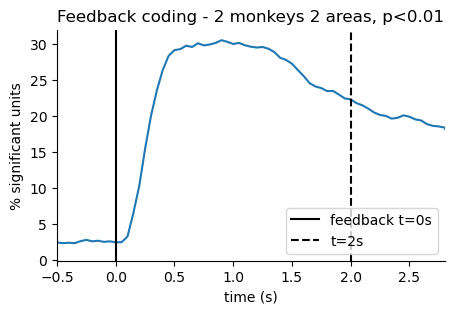

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(signifs_fb_01.time, signifs_fb_01.mean('unit')*100)
ax.axvline(0, color='black', label='feedback t=0s')
ax.axvline(2, color='black', linestyle='--', label='t=2s')
ax.set_ylabel('% significant units')
ax.set_xlabel('time (s)')
ax.legend(loc='lower right')

ax.set_title('Feedback coding - 2 monkeys 2 areas, p<0.01')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-.5, 2.8)

In [5]:
# load neuron info
floc = '/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/data/neural_summary.csv'

neuron_metadata = pd.read_csv(floc, dtype={'session': str})
# drop 'channel' column
neuron_metadata = neuron_metadata.drop(columns=['channel'])


In [6]:
# load clements neuron info
floc = '/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/data/neural_summary_Clement.csv'

data_clement = pd.read_csv(floc, sep=' ')

# new column: unit_id: {monkey}_{session}_{area}_{unit}
data_clement['session_per_day'] = [x.split('_')[-1] for x in data_clement['session']]
data_clement['session'] = [x.split('_')[1][2:] for x in data_clement['session']]
data_clement

,row.names,V1,V2,PiK,channel,unit,V1_amp,V2_amp,PiK_amp,V1_time,...,Vp2_LPFC,nfile,MCC_ap,LPFC_ap,MCC_lm,LPFC_lm,ap,lm,hclust,session_per_day
1,1,204,318,225,4,8,64.518476,36.788298,-173.212222,2.260121,...,qe,12,1.0,-5.0,7.0,-7.0,-5,-7,1,001
2,2,205,275,226,5,12,46.826451,70.965976,-266.121991,2.271255,...,qe,12,1.0,-5.0,7.0,-7.0,-5,-7,1,001
3,3,182,310,227,5,18,44.242398,33.866812,-110.571178,2.015182,...,qe,12,1.0,-5.0,7.0,-7.0,-5,-7,1,001
4,4,167,300,227,6,24,12.100969,34.011053,-91.043392,1.848178,...,qe,12,1.0,-5.0,7.0,-7.0,-5,-7,1,001
5,5,195,298,226,9,33,44.401495,49.231479,-175.521367,2.159919,...,qe,12,1.0,-5.0,7.0,-7.0,-5,-7,1,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5656,24,213,253,226,11,159,118.107729,60.841179,-397.212849,2.360324,...,ld,130,0.0,-6.0,3.0,-2.0,0,3,2,001
5657,25,191,302,223,11,161,30.750829,40.164185,-119.679336,2.115385,...,ld,130,0.0,-6.0,3.0,-2.0,0,3,1,001
5658,26,194,309,226,12,163,45.049530,66.474056,-255.119226,2.148785,...,ld,130,0.0,-6.0,3.0,-2.0,0,3,1,001
5659,27,189,274,226,13,165,23.277730,39.963287,-165.366704,2.093117,...,ld,130,0.0,-6.0,3.0,-2.0,0,3,1,001


In [7]:
# merge all

merged_df = pd.merge(unit_data, neuron_metadata, on=['monkey', 'session', 'area', 'unit_zs'], how='inner')
# reorder columns to be [monkey, session, area, subregion, unit, units_zs, etc]
colums = merged_df.columns.tolist()
new_order = ['monkey', 'session', 'area', 'subregion', 'unit', 'unit_zs'] + [col for col in colums if col not in ['monkey', 'session', 'area', 'subregion', 'unit', 'unit_zs']]
merged_df = merged_df[new_order]

merged_df = pd.merge(merged_df, data_clement, on=['monkey', 'session', 'area', 'unit'], how='inner')
merged_df

,monkey,session,area,subregion,unit,unit_zs,if_signif_05,beta_max_05,beta_min_05,if_signif_01,...,Vp2_LPFC,nfile,MCC_ap,LPFC_ap,MCC_lm,LPFC_lm,ap,lm,hclust,session_per_day
0,ka,230720,LPFC,dLPFC,67,LPFC_05_01,True,0.924730,0.343229,True,...,lk,15,2.0,1.0,3.0,-2.0,1,-2,1,002
1,ka,230720,LPFC,dLPFC,71,LPFC_06_01,False,NaN,NaN,False,...,lk,15,2.0,1.0,3.0,-2.0,1,-2,1,002
2,ka,230720,LPFC,dLPFC,97,LPFC_06_02,True,-0.485919,-0.700694,False,...,lk,15,2.0,1.0,3.0,-2.0,1,-2,1,002
3,ka,230720,LPFC,dLPFC,96,LPFC_06_03,False,NaN,NaN,False,...,lk,15,2.0,1.0,3.0,-2.0,1,-2,1,002
4,ka,230720,LPFC,dLPFC,15,LPFC_07_01,True,-0.143941,-0.422471,True,...,lk,15,2.0,1.0,3.0,-2.0,1,-2,1,002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,po,200722,MCC,MCC,35,MCC_13_02,True,0.497050,-0.315489,True,...,le,127,-1.0,-5.0,6.0,-2.0,-1,6,1,002
4890,po,200722,MCC,MCC,40,MCC_14_01,True,-0.243365,-0.502264,True,...,le,127,-1.0,-5.0,6.0,-2.0,-1,6,1,002
4891,po,200722,MCC,MCC,43,MCC_14_03,False,NaN,NaN,False,...,le,127,-1.0,-5.0,6.0,-2.0,-1,6,1,002
4892,po,200722,MCC,MCC,42,MCC_14_02,True,NaN,NaN,False,...,le,127,-1.0,-5.0,6.0,-2.0,-1,6,1,002


In [8]:
# save the merged dataframe
'''floc = '/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/glm/df_unit_significances.csv'

merged_df.to_csv(floc)'''

"floc = '/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/glm/df_unit_significances.csv'\n\nmerged_df.to_csv(floc)"